# A Simple AutoEncoder and Latent Space Visualization with PyTorch

## Preliminaries

In [1]:
import os
import random
from PIL import Image
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
import boto3
import io
import pickle
import pandas as pd
import numpy as np
import scipy
from tqdm import tqdm
import time
import random
from random import shuffle, randint, randrange

import matplotlib.pyplot as plt
import gc 
import math

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.simplefilter("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

2025-09-15 16:40:52.075313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda


In [2]:
suff = './pickles/new_pickles_800k_AE1/'

beat_sentence_file_name = suff +'beat_sentences_withID.pkl' 
beat_sentence_cnn_pickle_name = suff +'beat_sentences_cnn_withID.pkl' 
p_wave_cluster_pickle_name = suff +'p_wave_clustering_model.pkl'
qrs_wave_cluster_pickle_name= suff +'qrs_wave_clustering_model.pkl'
t_wave_cluster_pickle_name = suff +'t_wave_clustering_model.pkl'

p_wave_labels_filename = suff + 'p_wave_labels.pkl'
qrs_wave_labels_filename = suff + 'qrs_wave_labels.pkl'
t_wave_labels_filename = suff + 't_wave_labels.pkl'

p_model_save_path = suff + "p_ae_model.pth"
qrs_model_save_path = suff + "qrs_ae_model.pth"
t_model_save_path = suff + "t_ae_model.pth"

In [5]:
os.makedirs(suff, exist_ok=True)

In [4]:
# List of file paths for the patient wave data
start_time = time.time()
patient_wave_data_files = [
    './pickles/MIMIC/mimic_patient_wave_data_normalized_0.pkl',
    './pickles/MIMIC/mimic_patient_wave_data_normalized_1.pkl',
    './pickles/MIMIC/mimic_patient_wave_data_normalized_2.pkl',
    './pickles/MIMIC/mimic_patient_wave_data_normalized_3.pkl',
    './pickles/MIMIC/mimic_patient_wave_data_normalized_4.pkl',
    './pickles/MIMIC/mimic_patient_wave_data_normalized_5.pkl',
    './pickles/MIMIC/mimic_patient_wave_data_normalized_6.pkl',
    './pickles/MIMIC/mimic_patient_wave_data_normalized_7.pkl',
]

# Initialize an empty dictionary to store all merged data
patient_wave_data = {}

# Load and merge each file
for file_path in patient_wave_data_files:
    with open(file_path, 'rb') as file:
        patient_data = pickle.load(file)
        # Merge the loaded data into the main dictionary
        patient_wave_data.update(patient_data) 
end_time = time.time()
print((end_time-start_time)/60, ' minutes')
print("Number of patients:", len(patient_wave_data))

2.5310338656107585  minutes
Number of patients: 772633


In [5]:
nan_counts = {}

# Function to recursively check for NaN, None, or empty values
def check_nan_in_data(data):
    if isinstance(data, dict):
        # Recursively process dictionary
        return sum(check_nan_in_data(v) for v in data.values())
    elif isinstance(data, list):
        # Check each element in the list
        return sum(check_nan_in_data(v) for v in data)
    elif data is None or (isinstance(data, float) and np.isnan(data)) or (isinstance(data, str) and data == ''):
        # Base case: count if it's None, NaN, or empty
        return 1
    return 0

# Process each main key in patient_wave_data
for main_key, wave_data in patient_wave_data.items():
    nan_count = check_nan_in_data(wave_data)  # Count NaN/None/empty in the nested structure
    nan_counts[main_key] = nan_count

# Display the results
for key, count in nan_counts.items():
    if count > 0:  # Only show keys with issues
        print(f"Key: {key}, NaN/None/Empty Count: {count}")

# Total number of issues across all keys
total_issues = sum(nan_counts.values())
print(f"Total NaN/None/Empty Issues in the dataset: {total_issues}")

Total NaN/None/Empty Issues in the dataset: 0


In [6]:
# Calculate the total number of P, QRS, and T waves
total_p_waves = sum(len(waves['p_wave']) for waves in patient_wave_data.values())
total_qrs_waves = sum(len(waves['qrs_wave']) for waves in patient_wave_data.values())
total_t_waves = sum(len(waves['t_wave']) for waves in patient_wave_data.values())

print(f"Total P waves: {total_p_waves}")
print(f"Total QRS waves: {total_qrs_waves}")
print(f"Total T waves: {total_t_waves}")

Total P waves: 8144568
Total QRS waves: 8144568
Total T waves: 8144568


In [7]:
# Combine wave data from all patients for clustering and store indices

# We store each indices, for instance patient 1 has 5 p wave then it start
# and end is 0 and 5 , so all the labels after clustering will be assign to 
# this patient

combined_p_wave_data = []
combined_qrs_wave_data = []
combined_t_wave_data = []

patient_indices = {}

for patient, waves in patient_wave_data.items():
    # print('patient',patient)
    start_p = len(combined_p_wave_data)
    start_qrs = len(combined_qrs_wave_data)
    start_t = len(combined_t_wave_data)
    
    combined_p_wave_data.extend(waves['p_wave'])
    combined_qrs_wave_data.extend(waves['qrs_wave'])
    combined_t_wave_data.extend(waves['t_wave'])
    
    end_p = len(combined_p_wave_data)
    end_qrs = len(combined_qrs_wave_data)
    end_t = len(combined_t_wave_data)
    
    patient_indices[patient] = {
        'p_wave': (start_p, end_p),
        'qrs_wave': (start_qrs, end_qrs),
        't_wave': (start_t, end_t)
    }
    # print('len of waves p_wave',len(waves['p_wave']))
    # print('start_p',start_p)
    # print('end_p',end_p)

print("Number of combined P wave entries:", len(combined_p_wave_data))
print("Number of combined QRS wave entries:", len(combined_qrs_wave_data))
print("Number of combined T wave entries:", len(combined_t_wave_data))
# patient_indices

Number of combined P wave entries: 8144568
Number of combined QRS wave entries: 8144568
Number of combined T wave entries: 8144568


In [8]:
len(combined_p_wave_data[0])
max_len_p = max(len(seq) for seq in combined_p_wave_data)
max_len_p

325

In [9]:
len(combined_qrs_wave_data[0])
max_len_qrs = max(len(seq) for seq in combined_qrs_wave_data)
max_len_qrs

2665

In [10]:
len(combined_t_wave_data[0])

max_len_t = max(len(seq) for seq in combined_t_wave_data)
max_len_t

330

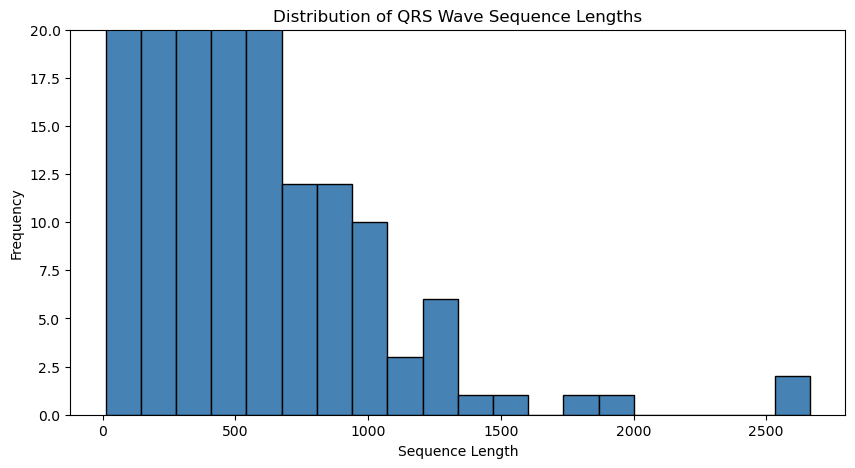

0.003% of sequences are longer than 400


In [11]:
##length histogram
lengths = [len(seq) for seq in combined_qrs_wave_data]

plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=20, color='steelblue', edgecolor='black')
plt.title("Distribution of QRS Wave Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.ylim(0, 20)
plt.show()
count_over_400 = sum(l > 400 for l in lengths)
percentage_over_400 = 100 * count_over_400 / len(lengths)
print(f"{percentage_over_400:.3f}% of sequences are longer than 400")

In [12]:
max_len = 400 #500
trimmed_qrs_wave_data = [seq[:max_len] for seq in combined_qrs_wave_data]
max_len_qrs = 400

In [13]:
np.save(suff + "raw_p_wave.npy",
        np.array(combined_p_wave_data, dtype=object),
        allow_pickle=True)

np.save(suff + "raw_qrs_wave.npy",
        np.array(trimmed_qrs_wave_data, dtype=object),
        allow_pickle=True)

np.save(suff + "raw_t_wave.npy",
        np.array(combined_t_wave_data, dtype=object),
        allow_pickle=True)

# Autoencoder with function

## skip!! run the train_ae.sh directly

In [16]:
import importlib, Autoencoder
importlib.reload(Autoencoder)           # force re‑read the latest file
from Autoencoder import extract_waves_with_AE
print("Imported OK →", extract_waves_with_AE)

[DDP] world_size=1, device=cuda:0
[DDP] world_size=1, device=cuda:0
Imported OK → <function extract_waves_with_AE at 0x7f1d57e9c040>


In [17]:
extract_waves_with_AE(combined_p_wave_data, p_model_save_path, max_len_p, "p_wave", 12)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 139]             128
       BatchNorm1d-2              [-1, 32, 139]              64
              GELU-3              [-1, 32, 139]               0
            Conv1d-4               [-1, 64, 70]           6,208
       BatchNorm1d-5               [-1, 64, 70]             128
              GELU-6               [-1, 64, 70]               0
            Conv1d-7              [-1, 128, 35]          24,704
       BatchNorm1d-8              [-1, 128, 35]             256
              GELU-9              [-1, 128, 35]               0
           Conv1d-10              [-1, 256, 18]          98,560
      BatchNorm1d-11              [-1, 256, 18]             512
             GELU-12              [-1, 256, 18]               0
           Linear-13                   [-1, 12]          36,876
          Encoder-14                   

Train:  17%|█▋        | 307/1786 [00:39<02:13, 11.08it/s, loss=0.0035448]

KeyboardInterrupt: 

Train:  17%|█▋        | 308/1786 [00:49<02:13, 11.08it/s, loss=0.0035448]

In [ ]:
#trim qrs waves
# !!!!!Caution: change the trimmed_qrs_wave_data to combined_qrs_wave_data if not trimming
# hyperparameters follow log_hyper_AE1_qrs
extract_waves_with_AE(trimmed_qrs_wave_data, qrs_model_save_path, max_len_qrs, "qrs_wave", 24)

In [ ]:
# hyperparameters follow log_hyper_AE1_p
extract_waves_with_AE(combined_t_wave_data, t_model_save_path, max_len_t, "t_wave", 12)

# Option 2: Main Clustering

In [ ]:
# bash train_ae.sh

In [3]:
combined_p_wave_data_compressed = np.load(suff+'p_wave_latent_space.npy')
combined_qrs_wave_data_compressed = np.load(suff+'qrs_wave_latent_space.npy')
combined_t_wave_data_compressed = np.load(suff+'t_wave_latent_space.npy')

In [6]:
print(combined_p_wave_data_compressed.shape)
print(combined_qrs_wave_data_compressed.shape)
print(combined_t_wave_data_compressed.shape)

(8144568, 12)
(8144568, 24)
(8144568, 12)


In [13]:
# normalize the latent vectors before clustering
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np

def verify_normalization(data, data_name, tolerance=1e-6):
    global_mean = np.mean(data)
    global_std = np.std(data)

    print(f"\n{data_name} NORMALIZATION CHECK")
    print(f"Data shape: {data.shape}")
    print(f"Global mean: {global_mean:.6f}")
    print(f"Global std: {global_std:.6f}")
    print(f"Min value: {np.min(data):.6f}")
    print(f"Max value: {np.max(data):.6f}")

    if abs(global_mean) < tolerance:
        print("Mean is correctly normalized")
    else:
        print("Mean normalization failed")

    if abs(global_std - 1.0) < tolerance:
        print("Standard deviation is correctly normalized")
    else:
        print("Standard deviation normalization failed")

# Before normalization - check original data
print("BEFORE NORMALIZATION")
print(f"P-wave data: mean={np.mean(combined_p_wave_data_compressed):.6f}, std={np.std(combined_p_wave_data_compressed):.6f}")
print(f"QRS-wave data: mean={np.mean(combined_qrs_wave_data_compressed):.6f}, std={np.std(combined_qrs_wave_data_compressed):.6f}")
print(f"T-wave data: mean={np.mean(combined_t_wave_data_compressed):.6f}, std={np.std(combined_t_wave_data_compressed):.6f}")

# Global normalization
scaler_p = StandardScaler()
scaler_qrs = StandardScaler()
scaler_t = StandardScaler()

combined_p_wave_data_scaled = scaler_p.fit_transform(combined_p_wave_data_compressed)
combined_qrs_wave_data_scaled = scaler_qrs.fit_transform(combined_qrs_wave_data_compressed)
combined_t_wave_data_scaled = scaler_t.fit_transform(combined_t_wave_data_compressed)

# Verify normalization for each wave type
verify_normalization(combined_p_wave_data_scaled, "P-WAVE")
verify_normalization(combined_qrs_wave_data_scaled, "QRS-WAVE")
verify_normalization(combined_t_wave_data_scaled, "T-WAVE")

# L2 normalization row-wise (spherical kmeans geometry)
normalizer_p = Normalizer(norm="l2")
normalizer_qrs = Normalizer(norm="l2")
normalizer_t = Normalizer(norm="l2")

combined_p_wave_data_scaled = normalizer_p.transform(combined_p_wave_data_scaled)
combined_qrs_wave_data_scaled = normalizer_qrs.transform(combined_qrs_wave_data_scaled)
combined_t_wave_data_scaled = normalizer_t.transform(combined_t_wave_data_scaled)


print("\nNORMALIZATION COMPLETE")
print("Ready for clustering!")

BEFORE NORMALIZATION
P-wave data: mean=0.630509, std=2.303173
QRS-wave data: mean=0.630270, std=7.496039
T-wave data: mean=0.660808, std=2.583995

P-WAVE NORMALIZATION CHECK
Data shape: (8144568, 12)
Global mean: -0.000000
Global std: 1.000001
Min value: -14.428777
Max value: 21.892069
Mean is correctly normalized
Standard deviation is correctly normalized

QRS-WAVE NORMALIZATION CHECK
Data shape: (8144568, 24)
Global mean: 0.000000
Global std: 1.000003
Min value: -15.227233
Max value: 13.828794
Mean is correctly normalized
Standard deviation normalization failed

T-WAVE NORMALIZATION CHECK
Data shape: (8144568, 12)
Global mean: -0.000000
Global std: 1.000000
Min value: -15.095833
Max value: 11.337235
Mean is correctly normalized
Standard deviation is correctly normalized

NORMALIZATION COMPLETE
Ready for clustering!


## Tuner

Optimal K for P wave: 13
Optimal K for QRS wave: 11
Optimal K for T wave: 10


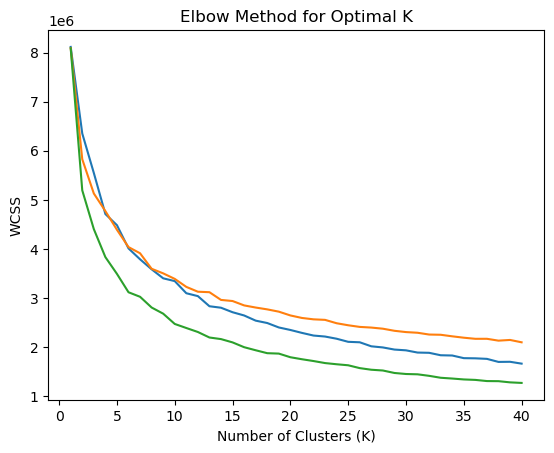

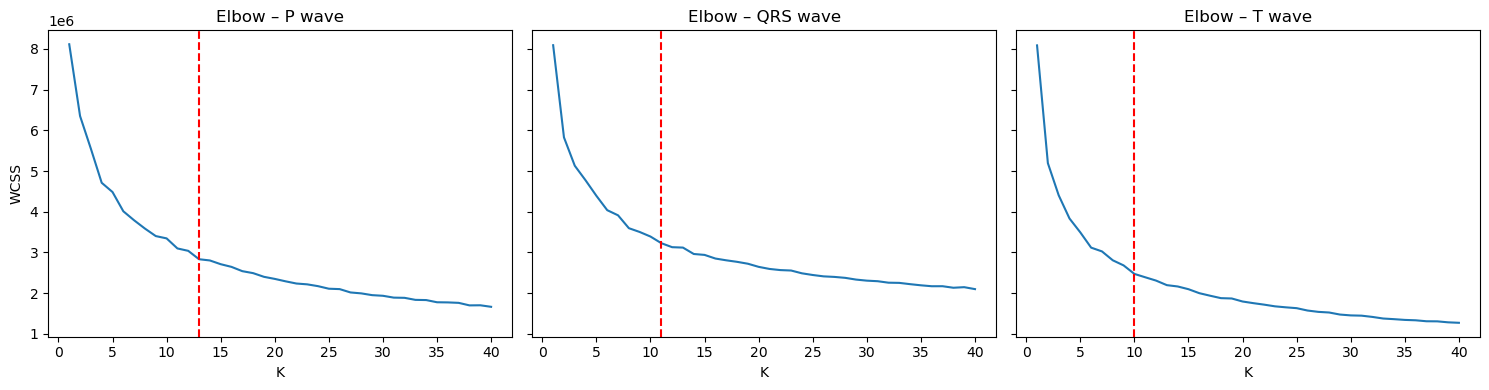

In [8]:
from kneed import KneeLocator

def calculate_wcss(data, max_clusters):
    wcss = []
    for i in range(1, max_clusters + 1):
        # kmeans = MiniBatchKMeans(n_clusters=i, batch_size=65536, init='k-means++', tol=1e-4, n_init="auto")
        kmeans = MiniBatchKMeans(
            n_clusters=i,
            init="k-means++",
            n_init=10,
            batch_size=65536,
            init_size=196608,     # max(3*65536, 50*512) = 196,608
            max_iter=31,          # ceil(2 * 1,015,560 / 65,536) = 31
            reassignment_ratio=0.01,
            tol=1e-4,
            verbose=0,
            compute_labels=False,
            random_state=42,
        )
        #######800k data################
        
        # kmeans_big = MiniBatchKMeans(
        #     n_clusters=i,
        #     init="k-means++",
        #     n_init=10,
        #     batch_size=65536,
        #     init_size=196608,
        #     max_iter=248,         # ceil(2 * 8,124,480 / 65,536) = 248
        #     reassignment_ratio=0.01,
        #     tol=1e-4,
        #     verbose=1,
        #     compute_labels=False,
        #     random_state=42,
        # )
        #######800k data################
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

def clustering(wave, max_clusters, wave_name):
    selected_data = wave

    # Calculate WCSS for the range of cluster values
    wcss = calculate_wcss(selected_data, max_clusters)

    # Plot the WCSS values to find the elbow point
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title(f'Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('WCSS')
    # plt.show()

    return wcss

# find the elbow point using KneeLocator
def find_optimal_k_with_kneed(wcss_values, max_clusters):
    k_values = range(1, max_clusters + 1)
    kl = KneeLocator(k_values, wcss_values, curve='convex', direction='decreasing')
    return kl.elbow

wave_to_elbow_p = combined_p_wave_data_scaled
wave_to_elbow_qrs = combined_qrs_wave_data_scaled
wave_to_elbow_t = combined_t_wave_data_scaled

# Perform clustering and determine the optimal number of clusters using the elbow method
max_clusters = 40
wcss_p = clustering(wave_to_elbow_p, max_clusters, "p wave")
wcss_qrs = clustering(wave_to_elbow_qrs, max_clusters, "qrs wave")
wcss_t = clustering(wave_to_elbow_t, max_clusters, "t wave")

# Find and print the optimal K for each wave
num_p_wave_clusters = find_optimal_k_with_kneed(wcss_p, max_clusters)
num_qrs_wave_clusters = find_optimal_k_with_kneed(wcss_qrs, max_clusters)
num_t_wave_clusters = find_optimal_k_with_kneed(wcss_t, max_clusters)

print(f"Optimal K for P wave: {num_p_wave_clusters}")
print(f"Optimal K for QRS wave: {num_qrs_wave_clusters}")
print(f"Optimal K for T wave: {num_t_wave_clusters}")

# plot figures
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)

axes[0].plot(range(1, max_clusters + 1), wcss_p)
axes[0].set_title('Elbow – P wave')
axes[0].set_xlabel('K'); axes[0].set_ylabel('WCSS')
axes[0].axvline(x=num_p_wave_clusters, color='r', linestyle='--')

axes[1].plot(range(1, max_clusters + 1), wcss_qrs)
axes[1].set_title('Elbow – QRS wave')
axes[1].set_xlabel('K')
axes[1].axvline(x=num_qrs_wave_clusters, color='r', linestyle='--')

axes[2].plot(range(1, max_clusters + 1), wcss_t)
axes[2].set_title('Elbow – T wave')
axes[2].set_xlabel('K')
axes[2].axvline(x=num_t_wave_clusters, color='r', linestyle='--')

fig.tight_layout()
plt.show()

# Run cluster

In [77]:
# def clustering(wave, num_clusters, model_filename):
#     selected_data = wave

#     # Applying Mini-Batch K-Means
#     # clustering_model = MiniBatchKMeans(n_clusters=num_clusters, batch_size=1024, init='k-means++', tol=1e-4, n_init='auto')
#     clustering_model = MiniBatchKMeans(
#             n_clusters=num_clusters,
#             init="k-means++",
#             n_init=10,
#             batch_size=65536,
#             init_size=196608,     # max(3*65536, 50*512) = 196,608
#             max_iter=31,          # ceil(2 * 1,015,560 / 65,536) = 31
#             reassignment_ratio=0.01,
#             tol=1e-4,
#             verbose=0,
#             compute_labels=False,
#             random_state=42,
#         )
#     clustering_model.fit(selected_data)
#     labels = clustering_model.predict(selected_data)

#     # Calculate the silhouette score
#     silhouette_avg = silhouette_score(selected_data, labels)
#     print(f"Silhouette Score for {model_filename}: {silhouette_avg}")

#     # Save the trained model and max_length as a pickle file
#     with open(model_filename, 'wb') as file:
#         pickle.dump({'model': clustering_model}, file)

#     print(f"Model and max_length saved to {model_filename}")

#     return labels

# # Function to perform clustering and handle empty data
# def perform_clustering(data, num_clusters, model_filename, wave_type):
#     if len(data) == 0:
#         print(f"No data to cluster for {wave_type}")
#         return []
#     return clustering(data, num_clusters, model_filename)

In [78]:
# conda create -n rapids-24.06 -y python=3.10
# conda activate rapids-24.06
# conda install -y -c rapidsai -c conda-forge -c nvidia rapids=24.06 cuda-version=11.8

# # python -m ipykernel install --user --name rapids-24.06 --display-name "Python (rapids-24.06)"

In [7]:
num_p_wave_clusters = 13
num_qrs_wave_clusters = 11
num_t_wave_clusters = 10

In [10]:
import kmeans_gpu, importlib
importlib.reload(kmeans_gpu)  
from kmeans_gpu import perform_clustering

In [8]:
#elbow before the flattened curve
save_dir = os.path.join(suff,f"{num_p_wave_clusters}_{num_qrs_wave_clusters}_{num_t_wave_clusters}_clusters")
os.makedirs(save_dir, exist_ok=True)

In [12]:
# data clustering for p waves and label generation
p_wave_labels = perform_clustering(combined_p_wave_data_scaled, num_p_wave_clusters, p_wave_cluster_pickle_name, 'P wave')
print('p wave is done')
np.save(os.path.join(save_dir, "p_wave_labels.npy"), p_wave_labels)


Clustering P wave: 8144568 samples, 12 dimensions
Target clusters: 13
cuML not available: No module named 'cuml'
GPU Setup: {'torch_cuda': True, 'cuml': False, 'device_count': 4, 'gpu_names': ['NVIDIA A10G', 'NVIDIA A10G', 'NVIDIA A10G', 'NVIDIA A10G']}

=== Trying PyTorch GPU ===
Using PyTorch GPU clustering: 8144568 samples, 12D
PyTorchKMeans using device: cuda
Fitting K-means: 8144568 samples, 12 features, 13 clusters
Iteration 0: loss=3096613.27, centroid_shift=1.447340
Iteration 20: loss=2748794.19, centroid_shift=0.043981
Iteration 40: loss=2736837.89, centroid_shift=0.005365
Iteration 60: loss=2736637.33, centroid_shift=0.001660
Iteration 80: loss=2736603.50, centroid_shift=0.000989
Iteration 100: loss=2736592.44, centroid_shift=0.000452
Iteration 120: loss=2736590.81, centroid_shift=0.000162
Converged after 129 iterations
PyTorch clustering completed in 15.23 seconds
Silhouette Score (sampled): 0.2027
Model saved to ./pickles/new_pickles_800k_AE1/p_wave_clustering_model.pkl
p 

In [13]:
# data clustering for qrs waves and label generation
qrs_labels = perform_clustering(combined_qrs_wave_data_scaled, num_qrs_wave_clusters, qrs_wave_cluster_pickle_name, 'QRS wave')
print('qrs is done')
qrs_wave_labels = [label + num_p_wave_clusters for label in qrs_labels]
np.save(os.path.join(save_dir, "qrs_wave_labels.npy"), qrs_wave_labels)


Clustering QRS wave: 8144568 samples, 24 dimensions
Target clusters: 11
cuML not available: No module named 'cuml'
GPU Setup: {'torch_cuda': True, 'cuml': False, 'device_count': 4, 'gpu_names': ['NVIDIA A10G', 'NVIDIA A10G', 'NVIDIA A10G', 'NVIDIA A10G']}

=== Trying PyTorch GPU ===
Using PyTorch GPU clustering: 8144568 samples, 24D
PyTorchKMeans using device: cuda
Fitting K-means: 8144568 samples, 24 features, 11 clusters
Iteration 0: loss=3661263.61, centroid_shift=1.641910
Iteration 20: loss=3124554.11, centroid_shift=0.009588
Iteration 40: loss=3124179.09, centroid_shift=0.000649
Converged after 60 iterations
PyTorch clustering completed in 7.43 seconds
Silhouette Score (sampled): 0.1765
Model saved to ./pickles/new_pickles_800k_AE1/qrs_wave_clustering_model.pkl
qrs is done


In [14]:
# data clustering for t waves and label generation
t_labels = perform_clustering(combined_t_wave_data_scaled, num_t_wave_clusters, t_wave_cluster_pickle_name, 'T wave')
print('t wave is done')
t_wave_labels = [label + num_p_wave_clusters + num_qrs_wave_clusters for label in t_labels]
np.save(os.path.join(save_dir, "t_wave_labels.npy"), t_wave_labels)


Clustering T wave: 8144568 samples, 12 dimensions
Target clusters: 10
cuML not available: No module named 'cuml'
GPU Setup: {'torch_cuda': True, 'cuml': False, 'device_count': 4, 'gpu_names': ['NVIDIA A10G', 'NVIDIA A10G', 'NVIDIA A10G', 'NVIDIA A10G']}

=== Trying PyTorch GPU ===
Using PyTorch GPU clustering: 8144568 samples, 12D
PyTorchKMeans using device: cuda
Fitting K-means: 8144568 samples, 12 features, 10 clusters
Iteration 0: loss=2723851.11, centroid_shift=1.137248
Iteration 20: loss=2385730.67, centroid_shift=0.009410
Iteration 40: loss=2385427.78, centroid_shift=0.000212
Converged after 45 iterations
PyTorch clustering completed in 5.21 seconds
Silhouette Score (sampled): 0.2252
Model saved to ./pickles/new_pickles_800k_AE1/t_wave_clustering_model.pkl
t wave is done


## after the data clustering is done, load the labels for use

In [9]:
p_wave_labels = np.load(os.path.join(save_dir, "p_wave_labels.npy"))
qrs_wave_labels = np.load(os.path.join(save_dir, "qrs_wave_labels.npy"))
t_wave_labels = np.load(os.path.join(save_dir, "t_wave_labels.npy"))

p_wave_labels_array = np.asarray(p_wave_labels, dtype=np.uint8)
qrs_wave_labels_array = np.asarray(qrs_wave_labels, dtype=np.uint8)
t_wave_labels_array = np.asarray(t_wave_labels, dtype=np.uint8)

In [16]:
# Function to check min and max values of cluster labels
def check_min_max(labels, wave_type):
    if not labels.size:
        print(f"No labels for {wave_type}")
        return
    min_value = min(labels)
    max_value = max(labels)
    print(f"Min and Max values for {wave_type} clusters: {min_value}, {max_value}")

# Check min and max values for each wave type
check_min_max(p_wave_labels_array, "P wave")
check_min_max(qrs_wave_labels_array, "QRS wave")
check_min_max(t_wave_labels_array, "T wave")

Min and Max values for P wave clusters: 0, 12
Min and Max values for QRS wave clusters: 13, 23
Min and Max values for T wave clusters: 24, 33


# Assign Label

In [17]:
# Assign labels to each patient's wave data and verify
p_cursor, qrs_cursor, t_cursor = 0, 0, 0

for patient, waves in patient_wave_data.items():
    n_p = len(waves['p_wave'])
    waves['p_wave_labels'] = p_wave_labels_array[p_cursor : p_cursor + n_p]
    p_cursor += n_p

    n_qrs = len(waves['qrs_wave'])
    waves['qrs_wave_labels'] = qrs_wave_labels_array[qrs_cursor : qrs_cursor + n_qrs]
    qrs_cursor += n_qrs

    n_t = len(waves['t_wave'])
    waves['t_wave_labels'] = t_wave_labels_array[t_cursor : t_cursor + n_t]
    t_cursor += n_t

    # example check
    if patient in ["mimic_1", "mimic_28"]:
        print(f"{patient}: {n_p} P waves labels {waves['p_wave_labels']}")
        print(f"{patient}: {n_qrs} QRS waves labels {waves['qrs_wave_labels']}")
        print(f"{patient}: {n_t} T waves labels {waves['t_wave_labels']}")

mimic_1: 15 P waves labels [2 2 6 2 2 2 2 2 2 2 2 2 6 2 2]
mimic_1: 15 QRS waves labels [21 21 21 21 21 21 21 21 21 21 21 21 21 21 21]
mimic_1: 15 T waves labels [26 26 26 26 32 32 26 26 32 24 32 32 26 32 26]
mimic_28: 16 P waves labels [ 2  2  5  2  1  4  8  7  6  2  1 10  0  7  5 12]
mimic_28: 16 QRS waves labels [13 18 18 13 19 19 18 18 18 18 19 19 18 18 18 19]
mimic_28: 16 T waves labels [30 28 28 28 28 28 30 28 28 28 30 28 28 28 28 30]


## Beat sentence formulation

In [18]:
import random
# Initialize a dictionary to store beat sentences for each patient
patient_beat_sentences = {}
patient_beat_sentences_with_cnn = {}
cnn_features_list = []

# Generate beat sentences for each patient
for patient, waves in patient_wave_data.items():
    p_labels = waves.get('p_wave_labels', [])
    qrs_labels = waves.get('qrs_wave_labels', [])
    t_labels = waves.get('t_wave_labels', [])
    
    p_wave_features = waves.get('p_wave_features', [])
    qrs_wave_features = waves.get('qrs_wave_features', [])
    t_wave_features = waves.get('t_wave_features', [])

    # Determine the minimum number of labels available to ensure we have pairs of P, QRS, and T labels
    num_sentences = min(len(p_labels), len(qrs_labels), len(t_labels))
    
    # Initialize the list to store beat sentences for the current patient
    patient_beat_sentences[patient] = []
    patient_beat_sentences_with_cnn[patient] = []
    
    # Generate sentences
    i = 0
    while i < num_sentences:
        # Randomly select the number of beats (1, 2, 6, or 8)
        num_beats = random.choice([1, 2, 6, 8])
        sentence = []
        cnn_sentence_features = []
        
        for _ in range(num_beats):
            if i >= num_sentences:
                break
            beat = [p_labels[i], qrs_labels[i], t_labels[i]]
            sentence.append(beat)
            cnn_sentence_features.append([p_wave_features[i], qrs_wave_features[i], t_wave_features[i]])

            i += 1
        if sentence:
            patient_beat_sentences[patient].append(sentence)
            patient_beat_sentences_with_cnn[patient].append(cnn_sentence_features)

    # Print the beat sentences for verification
    if patient in ['mimic_1', 'mimic_28']: 
        print(f"Patient: {patient}")
        print("Beat sentences:")
        for sentence in patient_beat_sentences[patient]:
            print("  Sentence:", sentence)

Patient: mimic_1
Beat sentences:
  Sentence: [[2, 21, 26]]
  Sentence: [[2, 21, 26]]
  Sentence: [[6, 21, 26]]
  Sentence: [[2, 21, 26], [2, 21, 32], [2, 21, 32], [2, 21, 26], [2, 21, 26], [2, 21, 32], [2, 21, 24], [2, 21, 32]]
  Sentence: [[2, 21, 32]]
  Sentence: [[6, 21, 26], [2, 21, 32]]
  Sentence: [[2, 21, 26]]
Patient: mimic_28
Beat sentences:
  Sentence: [[2, 13, 30], [2, 18, 28], [5, 18, 28], [2, 13, 28], [1, 19, 28], [4, 19, 28]]
  Sentence: [[8, 18, 30], [7, 18, 28]]
  Sentence: [[6, 18, 28], [2, 18, 28], [1, 19, 30], [10, 19, 28], [0, 18, 28], [7, 18, 28]]
  Sentence: [[5, 18, 28]]
  Sentence: [[12, 19, 30]]


In [19]:
print(beat_sentence_file_name)
print(beat_sentence_cnn_pickle_name)
print(len(patient_beat_sentences_with_cnn))

./pickles/new_pickles_800k_AE1/beat_sentences_withID.pkl
./pickles/new_pickles_800k_AE1/beat_sentences_cnn_withID.pkl
772633


In [20]:
# Save the object to a pickle file
with open(beat_sentence_file_name, 'wb') as file:
    pickle.dump(patient_beat_sentences, file)
    
# Count the number of keys in the dictionary
num_keys = len(patient_beat_sentences)

# Print the number of keys
print(f"The number of keys in the dictionary is: {num_keys}")

The number of keys in the dictionary is: 772633


In [21]:
# Save the object to a pickle file
with open(beat_sentence_cnn_pickle_name, 'wb') as file:
    pickle.dump(patient_beat_sentences_with_cnn, file)
    
# Count the number of keys in the dictionary
num_keys = len(patient_beat_sentences_with_cnn)

# Print the number of keys
print(f"The number of keys in the dictionary is: {num_keys}")

The number of keys in the dictionary is: 772633


## label distribution

Figure saved to ./pickles/new_pickles_800k_AE1/13_11_10_clusters/wave_label_distribution.png


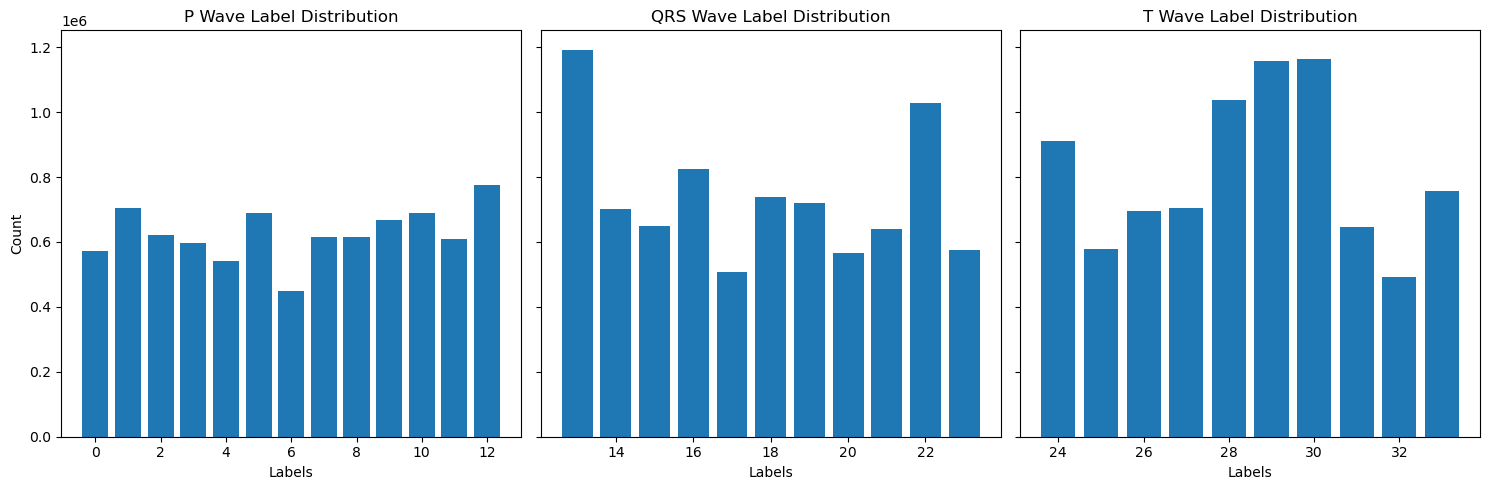

In [10]:
# # Subplot configuration
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for P wave labels
unique_labels_p, counts_p = np.unique(p_wave_labels_array, return_counts=True)
axes[0].bar(unique_labels_p, counts_p)
axes[0].set_title('P Wave Label Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')

# Plot for QRS wave labels
unique_labels_qrs, counts_qrs = np.unique(qrs_wave_labels_array, return_counts=True)
axes[1].bar(unique_labels_qrs, counts_qrs)
axes[1].set_title('QRS Wave Label Distribution')
axes[1].set_xlabel('Labels')

# Plot for T wave labels
unique_labels_t, counts_t = np.unique(t_wave_labels_array, return_counts=True)
axes[2].bar(unique_labels_t, counts_t)
axes[2].set_title('T Wave Label Distribution')
axes[2].set_xlabel('Labels')

# Adjust layout
plt.tight_layout()

save_dir = os.path.join(suff,f"{num_p_wave_clusters}_{num_qrs_wave_clusters}_{num_t_wave_clusters}_clusters")
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir,f"wave_label_distribution.png")
plt.savefig(file_path, dpi=300, bbox_inches="tight")
print(f"Figure saved to {file_path}")

plt.show()

## PCA

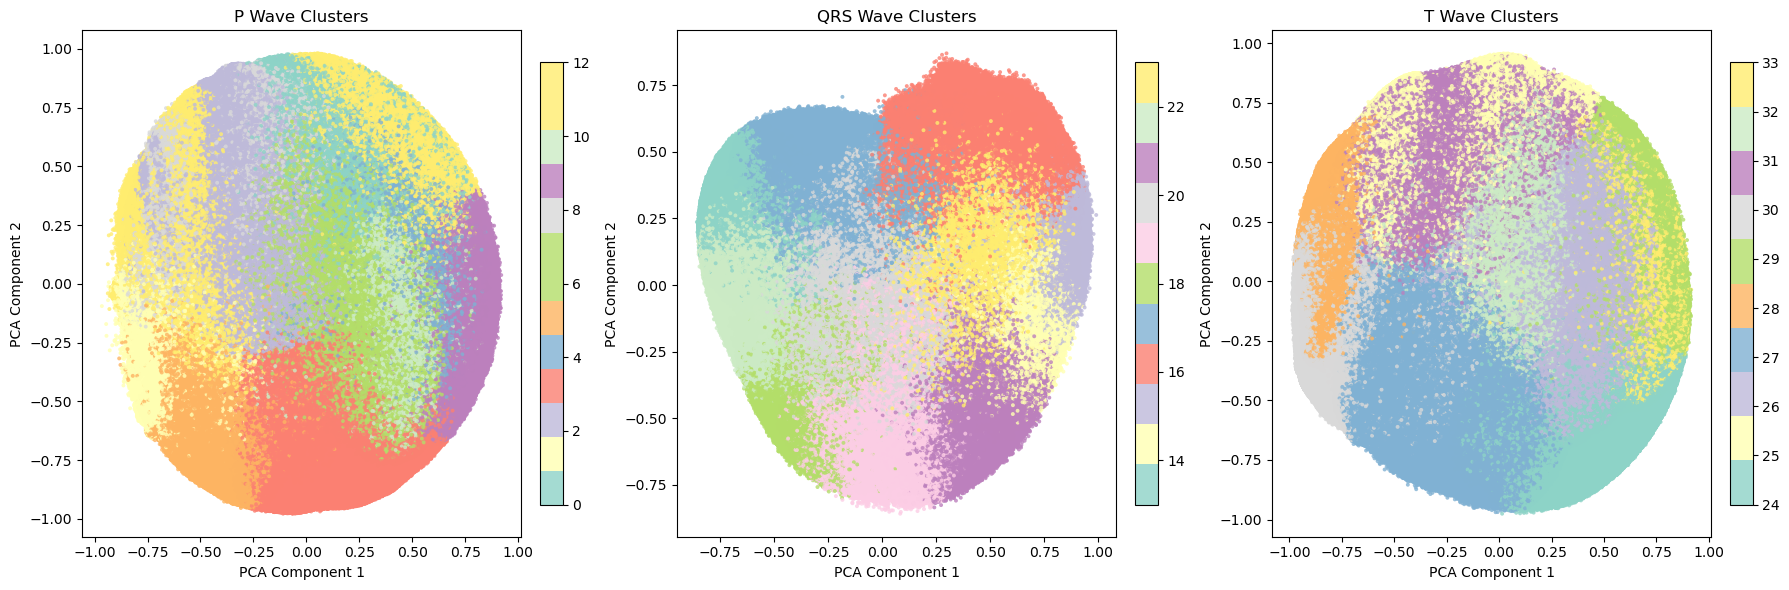

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

latent_P_2d   = PCA(n_components=2).fit_transform(combined_p_wave_data_scaled)
latent_QRS_2d = PCA(n_components=2).fit_transform(combined_qrs_wave_data_scaled)
latent_T_2d   = PCA(n_components=2).fit_transform(combined_t_wave_data_scaled)

# Discrete Set3 colormaps sized to the number of clusters (resamples if >12)
cmap_p   = plt.get_cmap('Set3', int(np.unique(p_wave_labels_array).size))
cmap_qrs = plt.get_cmap('Set3', int(np.unique(qrs_wave_labels_array).size))
cmap_t   = plt.get_cmap('Set3', int(np.unique(t_wave_labels_array).size))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sc1 = ax1.scatter(latent_P_2d[:, 0], latent_P_2d[:, 1],
                  c=p_wave_labels_array, cmap=cmap_p, alpha=0.8, s=8, edgecolors='none') # use 2 for all samples
ax1.set_title('P Wave Clusters')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')

sc2 = ax2.scatter(latent_QRS_2d[:, 0], latent_QRS_2d[:, 1],
                  c=qrs_wave_labels_array, cmap=cmap_qrs, alpha=0.8, s=8, edgecolors='none')
ax2.set_title('QRS Wave Clusters')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')

sc3 = ax3.scatter(latent_T_2d[:, 0], latent_T_2d[:, 1],
                  c=t_wave_labels_array, cmap=cmap_t, alpha=0.8, s=8, edgecolors='none')
ax3.set_title('T Wave Clusters')
ax3.set_xlabel('PCA Component 1')
ax3.set_ylabel('PCA Component 2')

fig.colorbar(sc1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(sc2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(sc3, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## TSNE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from openTSNE import TSNE

def tsne_three_panel(
    p_data, qrs_data, t_data,
    p_labels, qrs_labels, t_labels,
    perplexity=30, random_state=42
):
    # Fit a separate t-SNE per wave type (mirrors your PCA/UMAP usage)
    tsne_kwargs = dict(
        n_components=2,
        perplexity=perplexity,
        negative_gradient_method="fft",
        initialization="pca",
        random_state=random_state
    )
    emb_p = np.asarray(TSNE(**tsne_kwargs).fit(p_data))
    emb_qrs = np.asarray(TSNE(**tsne_kwargs).fit(qrs_data))
    emb_t = np.asarray(TSNE(**tsne_kwargs).fit(t_data))

    # Remap labels to 0..N-1 for clean discrete coloring
    p_lab = LabelEncoder().fit_transform(p_labels)
    qrs_lab = LabelEncoder().fit_transform(qrs_labels)
    t_lab = LabelEncoder().fit_transform(t_labels)

    nP, nQRS, nT = len(np.unique(p_lab)), len(np.unique(qrs_lab)), len(np.unique(t_lab))
    cmap_p = plt.get_cmap('Set3', nP)
    cmap_qrs = plt.get_cmap('Set3', nQRS)
    cmap_t = plt.get_cmap('Set3', nT)

    # Plot 3 subplots side-by-side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    ax1.scatter(emb_p[:, 0], emb_p[:, 1],
                c=p_lab, cmap=cmap_p, vmin=0, vmax=nP-1, alpha=0.7, s=5)
    ax1.set_xlabel('t-SNE 1'); ax1.set_ylabel('t-SNE 2'); ax1.set_title('P Wave (t-SNE)')

    ax2.scatter(emb_qrs[:, 0], emb_qrs[:, 1],
                c=qrs_lab, cmap=cmap_qrs, vmin=0, vmax=nQRS-1, alpha=0.7, s=5)
    ax2.set_xlabel('t-SNE 1'); ax2.set_ylabel('t-SNE 2'); ax2.set_title('QRS Wave (t-SNE)')

    ax3.scatter(emb_t[:, 0], emb_t[:, 1],
                c=t_lab, cmap=cmap_t, vmin=0, vmax=nT-1, alpha=0.7, s=5)
    ax3.set_xlabel('t-SNE 1'); ax3.set_ylabel('t-SNE 2'); ax3.set_title('T Wave (t-SNE)')

    plt.tight_layout()
    plt.show()

# Example call (note the corrected label vars for each wave)
tsne_three_panel(
    combined_p_wave_data_scaled,
    combined_qrs_wave_data_scaled,
    combined_t_wave_data_scaled,
    p_wave_labels_array,
    qrs_wave_labels_array,
    t_wave_labels_array
)

## UMAP

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import LabelEncoder

umap_p = UMAP(n_components=2, n_neighbors=15, min_dist=0.05, metric="euclidean", random_state=42)
umap_qrs = UMAP(n_components=2, n_neighbors=15, min_dist=0.05, metric="euclidean", random_state=42)
umap_t = UMAP(n_components=2, n_neighbors=15, min_dist=0.05, metric="euclidean", random_state=42)

latent_P_2d = umap_p.fit_transform(combined_p_wave_data_scaled)
latent_QRS_2d = umap_qrs.fit_transform(combined_qrs_wave_data_scaled)
latent_T_2d = umap_t.fit_transform(combined_t_wave_data_scaled)

p_lab_enc = LabelEncoder().fit_transform(p_wave_labels_array)
qrs_lab_enc = LabelEncoder().fit_transform(qrs_wave_labels_array)
t_lab_enc = LabelEncoder().fit_transform(t_wave_labels_array)

nP = int(np.unique(p_lab_enc).size)
nQRS = int(np.unique(qrs_lab_enc).size)
nT = int(np.unique(t_lab_enc).size)

cmap_p = plt.get_cmap('Set3', nP)
cmap_qrs = plt.get_cmap('Set3', nQRS)
cmap_t = plt.get_cmap('Set3', nT)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.scatter(latent_P_2d[:, 0], latent_P_2d[:, 1], c=p_lab_enc, cmap=cmap_p, vmin=0, vmax=nP-1, alpha=0.7, s=5)
ax1.set_xlabel('UMAP 1'); ax1.set_ylabel('UMAP 2');

ax2.scatter(latent_QRS_2d[:, 0], latent_QRS_2d[:, 1], c=qrs_lab_enc, cmap=cmap_qrs, vmin=0, vmax=nQRS-1, alpha=0.7, s=5)
ax2.set_xlabel('UMAP 1'); ax2.set_ylabel('UMAP 2');

ax3.scatter(latent_T_2d[:, 0], latent_T_2d[:, 1],c=t_lab_enc, cmap=cmap_t, vmin=0, vmax=nT-1, alpha=0.7, s=5)
ax3.set_xlabel('UMAP 1'); ax3.set_ylabel('UMAP 2');

plt.tight_layout()
plt.show()


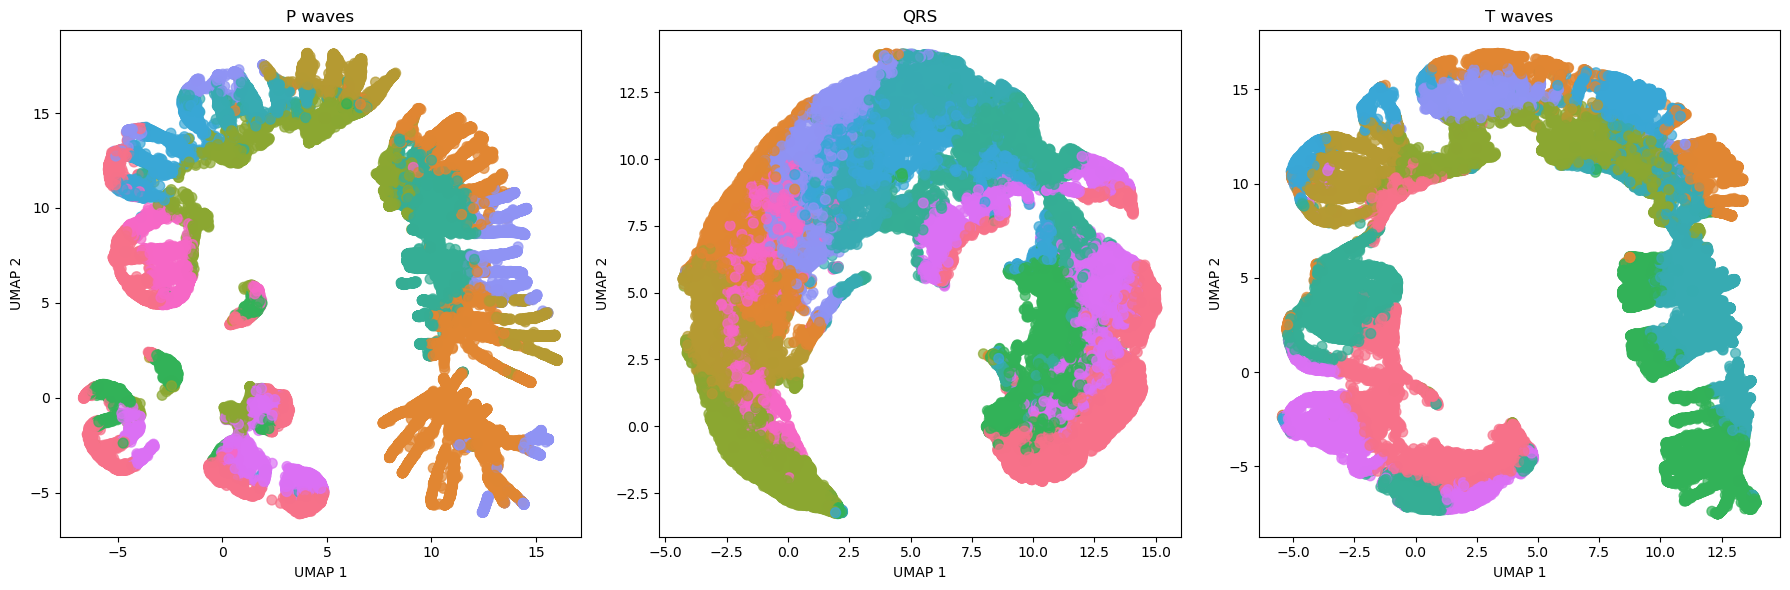

In [17]:
import seaborn as sns

# --- palette + helper ---
PALETTE_SIZE = 11
palette = sns.color_palette("husl", PALETTE_SIZE)

def colors_from_labels(lbl_enc, palette):
    k = len(palette)
    return np.array([palette[i % k] for i in lbl_enc])

# --- encoded labels (as you already had) ---
p_lab_enc = LabelEncoder().fit_transform(p_y)
qrs_lab_enc = LabelEncoder().fit_transform(qrs_y)
t_lab_enc = LabelEncoder().fit_transform(t_y)

# --- map labels -> colors ---
p_colors   = colors_from_labels(p_lab_enc, palette)
qrs_colors = colors_from_labels(qrs_lab_enc, palette)
t_colors   = colors_from_labels(t_lab_enc, palette)

# --- plot with size s=50 ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.scatter(latent_P_2d[:, 0],   latent_P_2d[:, 1],   c=p_colors,   alpha=0.7, s=50)
ax1.set_xlabel('UMAP 1'); ax1.set_ylabel('UMAP 2'); ax1.set_title('P waves')

ax2.scatter(latent_QRS_2d[:, 0], latent_QRS_2d[:, 1], c=qrs_colors, alpha=0.7, s=50)
ax2.set_xlabel('UMAP 1'); ax2.set_ylabel('UMAP 2'); ax2.set_title('QRS')

ax3.scatter(latent_T_2d[:, 0],   latent_T_2d[:, 1],   c=t_colors,   alpha=0.7, s=50)
ax3.set_xlabel('UMAP 1'); ax3.set_ylabel('UMAP 2'); ax3.set_title('T waves')

plt.tight_layout()
plt.show()
